# Data Validation and some simple Statistics

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from glob import glob

First read in the table with the generally available metadata from the CODH.

In [3]:
overview = pd.read_csv("bukan-overview.csv")

Next, I drop all the lines where I manually decided to not consider the book. This is mostly because is was not a book to begin with or the scan was useless.

In [4]:
data = overview[overview["K?"] == "x"].drop("K?", 1)

Just checking if the `metadata.json` and the actual number of images is consistent. 

In [5]:
label_mapping = {}
for idx in data["国文研書誌ID"]:
    idx = int(idx)
    with open(f"data/{idx}/manifest.json", "r", encoding="utf-8") as fd:
        manifest = json.load(fd)
        label = manifest["label"]
        alt_label = manifest["metadata"][3]["value"]
        if label in label_mapping and label_mapping[label] != alt_label:
            print(f"Inconsistent alternative label in {idx}: {label} <-> {alt_label}")
        label_mapping[label] = alt_label
        nr_pages = len(manifest["sequences"][0]["canvases"])
    images = glob(f"data/{idx}/image/*")
    if len(images) != nr_pages: print(f"WARNING book {idx}: {len(images)} images, {nr_pages} manifest pages")
    # print(f"book {idx}: {len(images)} images, {nr_pages} manifest pages")

WARNING book 200019503: 181 images, 180 manifest pages


## Mapping the names to latin letters

An hiragana reading is already included in the `metadata.json` but it's easier for me and for visualization to have latin letters. Therefore I created a manual mapping:

In [6]:
hiragana_mapping = {
    'ほんちょうぶかん': "honchōbukan",
    'たいへいぶかん': "taihenbukan",
    'たいへいぶかんたいぜん': "taihenbukantaizen",
    'せいとうぶかん': "seitōbukan",
    'げんろくぶかんたいぜん': "genrokubukantaizen",
    'ほうえいぶかんたいせい': "hōeibukantaisen",
    'ごりんぶかん': "gorinbukan",
    'ほうえいぶかん': "hōeibukan",
    'しょうふうぶかん': "shōfūbukan",
    'しょうえんぶかん': "shōenbukan",
    'しょうとくぶかん': "shōtokubukan",
    'きょうほうぶかん': "kyōhōbukan",
    'えいせいぶかん': "eiseibukan", 
    'げんぶんぶかん': "genbunbukan",
    'かんぽうぶかん': "kanpōbukan",
    'えんきょうぶかん': "enkyōbukan",
    'かんえんぶかん': "kanenbukan",
    'ゆうしぶかん': "yūshibukan",
    'ほうりゃくぶかん': "hōryakubukan",
    'たいせいぶかん': "taiseibukan",
    'めいわぶかん': "meiwabukan",
    'たいへいりゃくぶかん': "taiheiryakubukan",
    'しゅうぎょくぶかん': "shūgyokubukan",
    'あんえいぶかん': "aneibukan",
    'しゅうちんぶかん': "shūchinbukan",
    'てんめいぶかん': "tenmeibukan",
    'まんじゅぶかん': "manjubukan",
    'かんせいぶかん': "kanseibukan",
    'きょうわぶかん': "kyōwabukan",
    'ぶんかぶかん': "bunkabukan",
    'ぶんせいぶかん': "bunseibukan",
    'かまくらぶかん': "kamakurabukan",
    'かいほうりゃくぶかん': "kaihōryakubukan", 
    'てんぽうぶかん': "tenpōbukan",
    'おうにんぶかん': "ōninbukan",
    'こうかぶかん': "kōkabukan",
    'ばんせいぶかん': "banseibukan",
    'かえいぶかん': "kaeibukan",
    'しょうえいぶかん': "shōeibukan",
    'あんせいぶかん': "anseibukan",
    'ぶんきゅうぶかん': "bunkyūbukan",
    'けいおうぶかん': "keiōbukan",
    'おくにわけぶかん': "okuniwakebukan",
    'かいほうおくにわけりゃくぶかん': "kaihō okuniwake ryakubukan"
}

## How many of the same Bukan do we have?
There are many editions of the same bukan. But how are these distributed exactly? Let's plot the book title and the number of books!

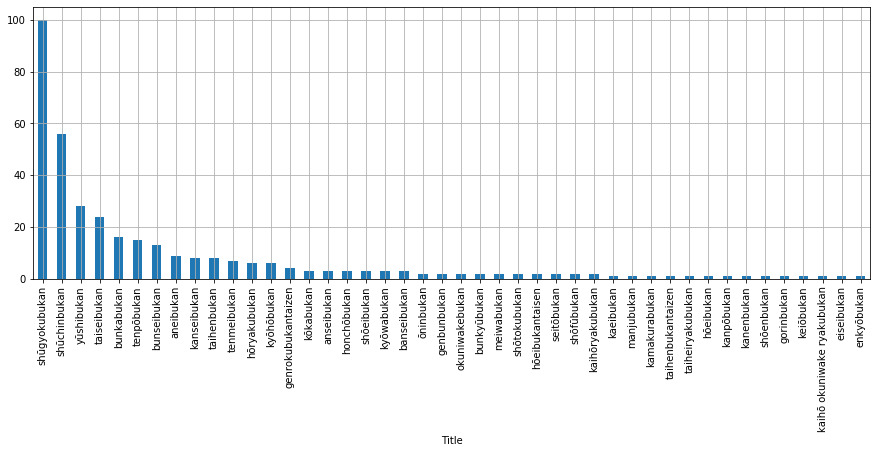

In [7]:
count_by_name = data.groupby("書名（統一書名）").count()["国文研書誌ID"]
count_by_name_index = count_by_name.index.map(label_mapping).map(hiragana_mapping)
count_by_name_index.name = "Title"
count_by_name.index = count_by_name_index
count_by_name_sorted = count_by_name.sort_values(ascending=False)
count_by_name_sorted.plot(kind="bar", figsize=(15,5), grid=True)

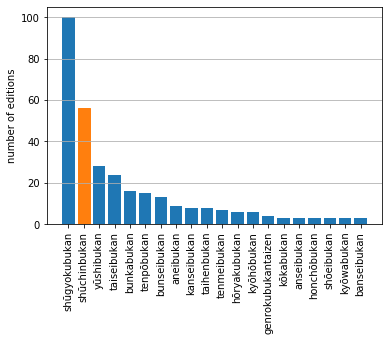

In [8]:
test = count_by_name_sorted[count_by_name_sorted>2]
bars = plt.bar(range(len(test)), test)
plt.ylabel("number of editions")
plt.xticks(range(len(test)), list(test.index), rotation="vertical")
plt.grid(axis="y")
bars[1].set_color("#ff7f0e")
#plt.savefig("bukan-distribution.pdf", transparent=True, bbox_inches="tight")

## Filtering out books

We can not compare books when there are not multiple editions available. Therefore I remove these lines from the overview table.

In [9]:
count_by_name_jap = data.groupby("書名（統一書名）").count()["国文研書誌ID"]
thresholded_larger_1 = data[data["書名（統一書名）"].map(lambda x: x in set(count_by_name_jap[count_by_name_jap > 1].index))]
thresholded_larger_1.shape

(338, 15)

### Shūgyoku Bukan

And this is the Bukan with the most editions:

The **袖玉武鑑** (しゅうぎょくぶかん) (shūgyokubukan)

In [10]:
shuugyokubukan = data[data["書名（統一書名）"] == "袖玉武鑑"]

In [11]:
# Output CSV for easier analysis in other software
shuugyokubukan.drop(
    ["書名（統一書名）", "X", "Y", "Width", "Height", "Comment", "(単位)", "冊数等", "刊・写", "オープンデータ分類", "公開時期"], 1).astype(
    {"国文研書誌ID":int, "（西暦）":int})#.to_csv(
#    "shuugyokubukan.csv", index=False)

,国文研書誌ID,原本請求記号,刊年・書写年,（西暦）
51,200019397,ＭＹ－１２０１－２２５,宝暦１４,1764
72,200019400,ＭＹ－１２０１－２２７,天明８,1788
73,200019401,ＭＹ－１２０１－２２８,天明９,1789
77,200019406,ＭＹ－１２０１－２３０,寛政１０,1798
82,200019408,ＭＹ－１２０１－２３１,文化３,1806
...,...,...,...,...
337,200019639,ＭＹ－１２０１－３１２,慶応３,1867
339,200019641,ＭＹ－１２０１－３１２,慶応３,1867
341,200019643,ＭＹ－１２０１－３１２,慶応３,1867
343,200019646,ＭＹ－１２０１－３１３,慶応３,1867


### Shūchin Bukan

Since most of the Bukan from above are really bad quality (better to look at this later) let's inspect the second most frequent:

The **袖珍武鑑** (しゅうちんぶかん) (shūchinbukan)

In [12]:
shuuchinbukan = data[data["書名（統一書名）"] == "袖珍武鑑"]

In [13]:
# Output CSV for easier analysis in other software
shuuchinbukan.drop(
    ["書名（統一書名）", "X", "Y", "Width", "Height", "Comment", "(単位)", "冊数等", "刊・写", "オープンデータ分類", "公開時期"], 1).astype(
    {"国文研書誌ID":int, "（西暦）":int})#.to_csv(
    #"shuuchinbukan.csv", index=False)

,国文研書誌ID,原本請求記号,刊年・書写年,（西暦）
59,200019399,ＭＹ－１２０１－２２６,安永７,1778
90,200019413,ＭＹ－１２０１－２３６,文化６,1809
112,200019419,ＭＹ－１２０１－２４２,文政７,1824
131,200019423,ＭＹ－１２０１－２４６,天保８,1837
138,200019429,ＭＹ－１２０１－２５１,天保１１,1840
142,200019430,ＭＹ－１２０１－２５２,天保１２,1841
171,200019451,ＭＹ－１２０１－２６６,嘉永４,1851
187,200019461,ＭＹ－１２０１－２７４,安政４,1857
190,200019464,ＭＹ－１２０１－２７６,安政５,1858
230,200019509,ＭＹ－１２０１－２９１,文久３,1863


### Yūshi Bukan

This looks better; but for completeness let's also process the third most frequent:

The **有司武鑑** (ゆうしぶかん) (yūshibukan)

In [14]:
yuushibukan = data[data["書名（統一書名）"] == "有司武鑑"]

In [15]:
# Output CSV for easier analysis in other software
yuushibukan.drop(
    ["書名（統一書名）", "X", "Y", "Width", "Height", "Comment", "(単位)", "冊数等", "刊・写", "オープンデータ分類", "公開時期"], 1).astype(
    {"国文研書誌ID":int, "（西暦）":int})#.to_csv(
    #"yuushibukan.csv", index=False)

,国文研書誌ID,原本請求記号,刊年・書写年,（西暦）
39,200019391,ＭＹ－１２０１－２２２,寛延１,1748
40,200019394,ＭＹ－１２０１－２２３,宝暦２,1752
121,200019421,ＭＹ－１２０１－２４４,文政１３,1830
136,200019428,ＭＹ－１２０１－２５０,天保９,1838
151,200019439,ＭＹ－１２０１－２５７,天保１５,1844
160,200019443,ＭＹ－１２０１－２６１,弘化４,1847
164,200019444,ＭＹ－１２０１－２６２,嘉永２,1849
168,200019446,ＭＹ－１２０１－２６４,嘉永３,1850
169,200019448,ＭＹ－１２０１－２６５,嘉永３,1850
181,200019456,ＭＹ－１２０１－２７０,安政２,1855
